In [19]:
from all_functions import *         ## This will import all the necessary functions 

In [4]:
def FRED_MD_DATA_PREP(index_type): 
    X = pd.read_csv('X_pca_top1.CSV')
    X = X.to_numpy()[:,1].reshape(-1,1)
    Y = pd.read_csv('Scaled_values_of_Y.CSV')
    Y = Y.to_numpy()[:,1:4]


    # We use X to predict Y = "UNRATE"
    if index_type == 'UNRATE':
        Y_axis = "UNRATE"
        Y = Y[:,0].reshape(-1,1)
    elif index_type == 'HOUST':
        Y_axis = "HOUST"
        Y = Y[:,1].reshape(-1,1)
    elif index_type == 'FEDFUNDS':
        Y_axis = "FEDFUNDS"
        Y = Y[:,2].reshape(-1,1)
    else: 
        raise Exception("Index type must be one of UNRATE, HOUST or FEDFUNDS!")

    # Remove outliers (w.r.t Y ) using IQR
    Data = np.hstack([X,Y])
    Q1 = np.percentile(Y, 25, interpolation = 'midpoint')

    Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    upper=Q3+1.5*IQR
    upper_array=np.array(Y<=upper)
    lower=Q1-1.5*IQR
    lower_array=np.array(Y>=lower)
    index_keep = upper_array & lower_array
    Data = Data[index_keep[:,0].tolist(),:]
    print("The number of data being removed is ", Y.shape[0]-Data.shape[0])
    return Data, Y_axis

In [6]:
def UTOPIA_FRED_MD(data, seed = 0):
    np.random.seed(seed)
    np.random.shuffle(Data)
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])
    X_pre = train_data[:,0].reshape(-1,1)
    Y_pre = train_data[:,1].reshape(-1,1)
    X_opt = train_data[:,0].reshape(-1,1)
    Y_opt = train_data[:,1].reshape(-1,1)
    X_adj = train_data[:,0].reshape(-1,1)
    Y_adj = train_data[:,1].reshape(-1,1)
    X_t = test_data[:,0].reshape(-1,1)
    Y_t = test_data[:,1].reshape(-1,1)


    n_pre = len(X_pre)
    n_opt = len(X_opt)
    n_adj = len(X_adj)
    n_t = len(X_t)

    # Obtain mean estimator
    known_mean = "False"
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN1"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)

    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre, X_opt,X_adj,X_t,est_type ="NN1")


    # Obtain quantile estimators
    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
    E_t = E_t.T


    # solve optimization problem

    optimal_weight, V100_adj, V100_t= solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

    # adjust interval
    alpha = 0.05
    delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha,stepsize = 0.001)

    # plot
    V_alpha_t = delta*V100_t
    return X_t,Y_t,M_t,V_alpha_t

In [13]:
def LQR_FRED_MD(data, seed):
    np.random.seed(seed)
    lin_idx = int(Data.shape[0] * 0.4)
    quantile_idx = int(Data.shape[0] * 0.8)
    lin_data, quantile_data, test_data = np.split(Data, [lin_idx, quantile_idx])

    X_lin = lin_data[:,0].reshape(-1,1)
    Y_lin = lin_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = quantile_data[:,0].reshape(-1,1)
    Y_quantile = quantile_data[:,1].reshape(-1,1)
    X_test = test_data[:,0].reshape(-1,1)
    Y_test = test_data[:,1].reshape(-1,1)

    # Estimate the mean using NN1
    est_type = "NN1"
    M_quantile, M_test = mean_est_others(est_type,X_lin,Y_lin,X_quantile,X_test)

    # Estimate the quantile
    alpha = 0.05

    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0)
    model_quantile.fit(X_quantile, Y_quantile-M_quantile)
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    return X_test,Y_test,M_test,V_test

In [14]:
def SplitCF_FRED_MD(data, seed): 
    np.random.seed(seed)
    lin_idx = int(Data.shape[0] * 0.4)
    res_idx = int(Data.shape[0] * 0.8)
    lin_data, res_data, test_data = np.split(Data, [lin_idx, res_idx])


    X_lin = lin_data[:,0].reshape(-1,1)
    Y_lin = lin_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_res = res_data[:,0].reshape(-1,1)
    Y_res = res_data[:,1].reshape(-1,1)
    y_res = Y_res[:,0]
    X_test = test_data[:,0].reshape(-1,1)
    Y_test = test_data[:,1].reshape(-1,1)
    y_test = Y_test[:,0]

    # Estimate the mean using NN1
    est_type = "NN1"
    Y_res_pred, M_test = mean_est_others(est_type,X_lin,Y_lin,X_res,X_test)
    y_res_pred = Y_res_pred[:,0]

    # Calculate the conformity scores
    residuals = np.abs(y_res - y_res_pred)

    alpha = 0.05  # 95% confidence level
    k = int((1 - alpha) * len(y_lin))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    # Calculate the prediction interval
    v_test = (threshold**2)*np.ones(len(y_test))
    V_test = v_test.reshape(-1,1)
    return X_test,Y_test,M_test,V_test

/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_73835/3692841010.py:23: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
/var/folders/42/lzyqp82x5n97th0ryxnzvq440000gn/T/ipykernel_73835/3692841010.py:25: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


The number of data being removed is  8


/Users/dm8341/anaconda3/lib/python3.10/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dm8341/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


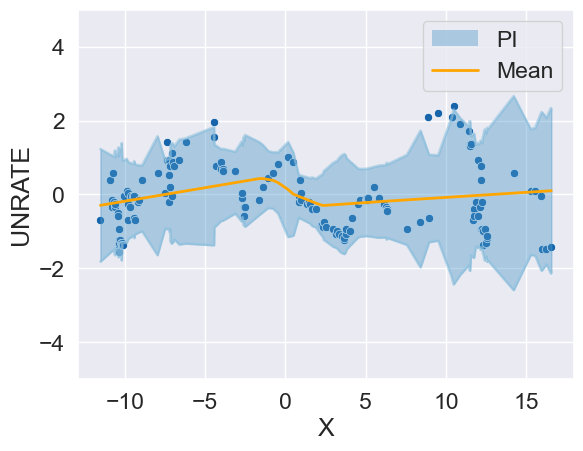

The overall coverage is 0.9463087248322147
The mean bandwidth for testing data is 1.6735786768121612


NameError: name 'mean_est_others' is not defined

In [21]:
## All methods for UNRATE 

Data, Y_axis = FRED_MD_DATA_PREP('UNRATE')

seed_no = 13

X_t,Y_t,M_t,V_alpha_t = UTOPIA_FRED_MD(Data, seed = seed_no)
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = "X", Y_axis = Y_axis,ylim = [-5,5])

X_test,Y_test,M_test,V_test = LQR_FRED_MD(Data, seed = seed_no)
my_plot(X_test,Y_test,M_test,V_test,X_axis = "X", Y_axis = Y_axis,ylim = [-5,5])

X_test,Y_test,M_test,V_test = SplitCF_FRED_MD(Data, seed_no)
my_plot(X_test,Y_test,M_test,V_test,X_axis = "X", Y_axis = Y_axis,ylim = [-5,5])

In [15]:
X_test,Y_test,M_test,V_test = LQR_FRED_MD(Data, seed = seed_no)

NameError: name 'mean_est_others' is not defined

In [20]:
mean_est_others

NameError: name 'mean_est_others' is not defined